In [1]:
import sqlite3 as sql
import os
import csv
from sqlite3 import Error
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import ast

import pygad
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import tqdm
from scipy.signal import find_peaks, peak_prominences, peak_widths, savgol_filter
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

import shutil
import os

In [2]:
try:

  # Connect to database
  conn=sql.connect('minspec.db')


 # To view table data in table format
  print("******Mineral Table Data*******")
  cur = conn.cursor()
  cur.execute('''SELECT * FROM minerals''')
  rows = cur.fetchall()
   
  #for row in rows:
  #    print(row)

 # Export data into CSV file
  print("Exporting data into CSV............")
  cursor = conn.cursor()
  cursor.execute("select * from minerals")
  with open("RAWmineral_data.csv", "w") as csv_file:
      csv_writer = csv.writer(csv_file, delimiter="\t")
      csv_writer.writerow([i[0] for i in cursor.description])
      csv_writer.writerows(cursor)

  dirpath = os.getcwd() + "/RAWmineral_data.csv"
  print("Data exported Successfully into {}".format(dirpath))

except Error as e:
  print(e)

# Close database connection
finally:
  conn.close()

******Mineral Table Data*******
Exporting data into CSV............
Data exported Successfully into c:\Users\maril\Downloads\HAPKE_MIXING-master\HAPKE_MIXING-master/RAWmineral_data.csv


In [3]:
with open("RAWmineral_data.csv", 'r') as temp_f:
# get number of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

# Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

# Read csv
df = pd.read_csv("RAWmineral_data.csv", header=None, delimiter="\t", 
names=column_names)
col_names = list(df.iloc[0])
df = pd.read_csv("RAWmineral_data.csv", header=None, delimiter="\t", names=col_names)
df.drop(0, inplace=True); df.reset_index(drop=True, inplace=True)

# Convert reflectances to lists of floats
df['reflectances'] = df['reflectances'].apply(lambda x: list(map(float, eval(x))) if x != 'None' else None)

# Calculate the mean reflectances for each group
mean_reflectances = df.groupby(['name', 'sampleID'])['reflectances'].apply(
    lambda x: np.mean(x.tolist(), axis=0) if x.notnull().any() else None
)

# Remove duplicate rows based on 'name' and 'sampleID'
df.drop_duplicates(subset=['name', 'sampleID'], keep='first', inplace=True)

# Overwrite the 'reflectances' column with the mean reflectances
df['reflectances'] = df.apply(
    lambda row: mean_reflectances[(row['name'], row['sampleID'])] if (row['name'], row['sampleID']) in mean_reflectances.index else None,
    axis=1
)

# Remove special characters from the "chemical_formula" column
df["chemical_formula"] = df["chemical_formula"].str.replace(r"[#&_\s]", "")

# Convert reflectances to comma-separated strings
df['reflectances'] = df['reflectances'].apply(lambda x: ', '.join(map(str, x)) if x is not None else None)

# Save the DataFrame to a CSV file
df.to_csv('output.csv', index=False)


df


,name,chemical_formula,sampleID,sample_purity,wavelengths,reflectances
0,Lizardite,Mg3Si2O5(OH)4,NMNHR4687.b_165um,NIC4aa,"[1.3447871, 1.345136, 1.3454852, 1.3458345, 1....","0.54064333, 0.54122853, 0.54210639, 0.54196006..."
1,Bloedite,Na2Mg(SO4)2*4H2O,GDS147,NIC4aau,"[1.5283473, 1.528798, 1.529249, 1.5297003, 1.5...","0.15803361, 0.15800314, 0.1580946, 0.15824707,..."
2,Illite,"(K,H3O)(Al,Mg,Fe)2(Si,Al)4O10[(OH)2,H2O]",IMt-1.b_lt2um,NIC4aa,"[1.3894811, 1.3898535, 1.3902262, 1.3905991, 1...","0.33545622, 0.33515427, 0.33545622, 0.33515427..."
3,Jarosite,K(Fe+3)3(SO4)2(OH)6,GDS98_K_90C_Syn,NIC4aa,"[1.4340675, 1.4344643, 1.4348613, 1.4352585, 1...","0.7534914, 0.75223202, 0.75242579, 0.75184453,..."
4,Anhydrite,CaSO4,GDS42_lt250um,NIC4aa,"[1.7217383, 1.7223103, 1.7228827, 1.7234554, 1...","0.77212828, 0.77273488, 0.77288651, 0.7733416,..."
...,...,...,...,...,...,...
107,Water_Ice,H2O,300micron_irr_80K,Not given,"[0.45, 0.5, 0.55, 0.6, 0.65, 0.700000000000000...","0.87419, 0.89482, 0.91041, 0.90928, 0.90426, 0..."
109,Water_Ice,H2O,300micron_irr_100K,Not given,"[0.45, 0.5, 0.55, 0.6, 0.65, 0.700000000000000...","0.98113, 0.9378, 0.9098, 0.90286, 0.90069, 0.8..."
110,Water_Ice,H2O,1060micron_120K,Not given,"[0.45, 0.5, 0.55, 0.6, 0.65, 0.700000000000000...","0.75039, 0.77018, 0.77242, 0.76489, 0.76332, 0..."
116,Water_Ice,H2O,680micron_140K,Not given,"[0.45, 0.5, 0.55, 0.6, 0.65, 0.700000000000000...","0.80806, 0.84044, 0.83142, 0.82549, 0.81313, 0..."


In [4]:
df['reflectances'] = df['reflectances'].apply(lambda x: ast.literal_eval(x))
df['wavelengths'] = df['wavelengths'].apply(lambda x: ast.literal_eval(x))

df['wavelengths'] = df['wavelengths'].apply(lambda x: np.array(x))
df['reflectances'] = df['reflectances'].apply(lambda x: np.array(x))

df['wavenumbers'] = df['wavelengths'].apply(lambda x: 1/x*(10**6)/(10**2))

In [5]:
dataframe = df
dataframe = dataframe[0:41]
dataframe

,name,chemical_formula,sampleID,sample_purity,wavelengths,reflectances,wavenumbers
0,Lizardite,Mg3Si2O5(OH)4,NMNHR4687.b_165um,NIC4aa,"[1.3447871, 1.345136, 1.3454852, 1.3458345, 1....","[0.54064333, 0.54122853, 0.54210639, 0.5419600...","[7436.12130128256, 7434.192527744406, 7432.263..."
1,Bloedite,Na2Mg(SO4)2*4H2O,GDS147,NIC4aau,"[1.5283473, 1.528798, 1.529249, 1.5297003, 1.5...","[0.15803361, 0.15800314, 0.1580946, 0.15824707...","[6543.015452050721, 6541.086526800794, 6539.15..."
2,Illite,"(K,H3O)(Al,Mg,Fe)2(Si,Al)4O10[(OH)2,H2O]",IMt-1.b_lt2um,NIC4aa,"[1.3894811, 1.3898535, 1.3902262, 1.3905991, 1...","[0.33545622, 0.33515427, 0.33545622, 0.3351542...","[7196.931286075068, 7195.00292656744, 7193.074..."
3,Jarosite,K(Fe+3)3(SO4)2(OH)6,GDS98_K_90C_Syn,NIC4aa,"[1.4340675, 1.4344643, 1.4348613, 1.4352585, 1...","[0.7534914, 0.75223202, 0.75242579, 0.75184453...","[6973.172462244629, 6971.24355064117, 6969.314..."
4,Anhydrite,CaSO4,GDS42_lt250um,NIC4aa,"[1.7217383, 1.7223103, 1.7228827, 1.7234554, 1...","[0.77212828, 0.77273488, 0.77288651, 0.7733416...","[5808.083609454468, 5806.154674915433, 5804.22..."
5,Thenardite,Na2SO4,GDS146,NIC4ccu,"[1.6000477, 1.6005416, 1.6010358, 1.6015304, 1...","[0.55983526, 0.56018364, 0.56035775, 0.5594868...","[6249.813677429742, 6247.8850908967315, 6245.9..."
6,Epsomite,MgSO4*7H2O,GDS149,NIC4ccu,"[1.4782305, 1.478652, 1.4790739, 1.479496, 1.4...","[0.073769517, 0.073750027, 0.073633045, 0.0736...","[6764.844860121611, 6762.916494212295, 6760.98..."
7,Tremolite,Ca2Mg5Si8O22(OH)2,HS18.3B,NIC4ccc,"[1.3780315, 1.3783978, 1.3787644, 1.3791313, 1...","[0.48758045, 0.48654085, 0.48602104, 0.4855878...","[7256.7281662284195, 7254.799739233479, 7252.8..."
8,Antigorite,"(Mg,Fe+2)3Si2O5(OH)4",NMNH96917.a_gt250,NIC4bb,"[1.3500402, 1.3503917, 1.3507435, 1.3510957, 1...","[0.33991614, 0.34071904, 0.34081936, 0.3404178...","[7407.186837843791, 7405.258785284299, 7403.33..."
9,Jarosite,K(Fe+3)3(SO4)2(OH)6,GDS99_K_200C_Syn,NIC4aa,"[1.4242183, 1.4246095, 1.425001, 1.425393, 1.4...","[0.7620815, 0.76145524, 0.7607246, 0.76020271,...","[7021.395526233583, 7019.467440024792, 7017.53..."


In [6]:
import numpy as np
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.optimize import minimize_scalar, root_scalar
from warnings import warn

PI = np.pi

###############################################################################
#                         HAPKE MODEL FUNCTIONS (UPDATED)                     #
###############################################################################

def fresnel_coefficient(n, k):
    """
    Computes the Fresnel reflectance at zero incidence angle (R0).
    """
    R0 = ((n - 1)**2 + k**2) / ((n + 1)**2 + k**2)
    return R0

def H_function(w, x):
    """
    Computes the multiple scattering function H(x).
    """
    gamma = np.sqrt(1 - w)
    r0 = (1 - gamma) / (1 + gamma)
    # Ensure x > 0 to avoid division by zero or log of zero
    x = np.clip(x, 1e-6, 1)
    Hx = 1 / (1 - w * x * (r0 + ((1 - 2 * r0 * x) / 2) * np.log((1 + x) / x)))
    return Hx

def phase_function(b, c, g):
    """
    Computes the single-particle phase function.
    """
    cos_g = np.cos(g)
    denominator1 = (1 + 2 * b * cos_g + b**2)**1.5
    denominator2 = (1 - 2 * b * cos_g + b**2)**1.5
    P = ((1 - c) / 2) * (1 - b**2) / denominator1 + \
        ((1 + c) / 2) * (1 - b**2) / denominator2
    return P

def porosity_parameter(phi):
    """
    Computes the porosity parameter K.
    """
    if phi == 0:
        K = 1
    else:
        K = -np.log(1 - 1.209 * phi**(2/3)) / (1.209 * phi**(2/3))
    return K

def shoe(B_S0, phi, g):
    """
    Computes the shadow-hiding opposition effect term (B_SH).
    """
    h_s = 3 * porosity_parameter(phi) * phi / 8
    # Avoid division by zero
    h_s = np.clip(h_s, 1e-6, None)
    B_SH = (1 + np.tan(g / 2) / h_s)**(-1)
    return 1 + B_S0 * B_SH

def hapke_reflectance(w, mu0, mu, g, params):
    """
    Computes the bidirectional reflectance using Hapke's model for given w.
    """
    theta_bar = params.get('theta_bar', 0)
    b = params.get('b', 0)
    c = params.get('c', 0)
    phi = params.get('phi', 0.4)
    K = porosity_parameter(phi)
    
    p = phase_function(b, c, g)
    B_S0 = params.get('B_S0', 0)  # Allow B_S0 to be set in params
    B_SH = shoe(B_S0, phi, g)
    # Compute shadowing function S with surface roughness
    S = roughness_correction(mu0, mu, g, theta_bar)
    
    H_mu0 = H_function(w, mu0)
    H_mu = H_function(w, mu)
    
    # Avoid division by zero
    denom = mu0 + mu
    denom = np.clip(denom, 1e-6, None)
    
    r = (K * w / (4 * PI)) * (mu0 / denom) * \
        (p * B_SH + H_mu0 * H_mu - 1) * S
    
    R = r * PI  # Convert to reflectance factor
    return R

def roughness_correction(mu0, mu, g, theta_bar):
    """
    Computes the roughness correction factor S according to Hapke's model.
    """
    if theta_bar == 0:
        return 1  # No roughness correction needed
    
    # Convert theta_bar to radians if not already
    if theta_bar > PI / 2:
        theta_bar = np.radians(theta_bar)
    
    # Compute the roughness correction factor S
    # Using Hapke's approximation for rough surfaces
    # For simplicity, we'll use the Lambertian roughness correction
    cos_theta_bar = np.cos(theta_bar)
    S = cos_theta_bar / (mu0 + mu)
    S = np.clip(S, 1e-6, 1)  # Ensure S is within valid range
    return S

# def invert_hapke_reflectance_vectorized(R_meas, mu0, mu, g, params):
#     """
#     Vectorized inversion of Hapke's model to estimate w from measured reflectance R_meas.
#     """
#     # Initial guesses for w
#     w_initial = np.full_like(R_meas, 0.5)
    
#     # Bounds for w: [0, 1]
#     bounds = (0, 1)
    
#     # Define the objective function vectorized over w
#     def objective(w):
#         R_model = hapke_reflectance(w, mu0, mu, g, params)
#         return R_model - R_meas
    
#     # Use root finding over arrays
#     from scipy.optimize import root
#     res = root(objective, w_initial, method='lm')
    
#     if not res.success:
#         warn("Inversion did not converge for all wavelengths. Using fallback values where necessary.")
#         w_est = np.clip(res.x, 0, 1)
#     else:
#         w_est = np.clip(res.x, 0, 1)
    
#     return w_est

from scipy.optimize import root_scalar
from warnings import warn

def invert_hapke_reflectance_detailed(R_meas, mu0, mu, g, params, wav_common):
    """
    Inverts the Hapke model to estimate w for each wavelength with detailed logging.
    """
    w_est = np.zeros_like(R_meas)
    for idx, R in enumerate(R_meas):
        # Skip if R is NaN or not finite
        if not np.isfinite(R):
            warn(f"Reflectance at index {idx} is invalid: {R}")
            w_est[idx] = np.nan
            continue

        # Define the objective function for a single wavelength
        def objective(w):
            return hapke_reflectance(w, mu0, mu, g, params) - R

        # Use a bounded scalar root-finding method
        try:
            sol = root_scalar(
                objective,
                bracket=[1e-6, 1 - 1e-6],
                method='brentq',
                xtol=1e-8,
                rtol=1e-8,
                maxiter=100
            )
            if sol.converged:
                w_est[idx] = sol.root
            else:
                warn(f"Inversion did not converge at index {idx}, wavelength {wav_common[idx]:.4f} µm.")
                w_est[idx] = np.nan
        except Exception as e:
            warn(f"Inversion failed at index {idx}, wavelength {wav_common[idx]:.4f} µm: {e}")
            w_est[idx] = np.nan
    return w_est


###############################################################################
#                         REFLECTANCE MIXING FUNCTIONS                        #
###############################################################################


def mix_single_scattering_albedo(w_list, fractions):
    """
    Mixes single-scattering albedos of multiple components.
    """
    w_mix = np.zeros_like(w_list[0])
    for w, f in zip(w_list, fractions):
        w_mix += f * w
    # Ensure w_mix is within [0, 1]
    w_mix = np.clip(w_mix, 0, 1)
    return w_mix

def compute_mixed_reflectance(wav_common, w_mix, angles, params):
    """
    Computes the reflectance of the mixture using Hapke's model.
    """
    inc_deg, eme_deg, phase_deg = angles
    i = np.radians(inc_deg)
    e = np.radians(eme_deg)
    g = np.radians(phase_deg)
    mu0 = np.cos(i)
    mu = np.cos(e)

    R_mix = hapke_reflectance(w_mix, mu0, mu, g, params)
    return R_mix

###############################################################################
#                         REFRACTIVE INDEX MODELING                           #
###############################################################################

def cauchy_equation(wavelength, A, B, C=0):
    """
    Calculates the refractive index n using Cauchy's equation.
    Wavelength should be in microns.
    """
    wavelength = np.clip(wavelength, 1e-6, None)
    n = A + B / wavelength**2 + C / wavelength**4
    return n

def model_nk_wavelength_dependence(wav_common, n_scalar, k_scalar):
    """
    Models the wavelength dependence of n and k using Cauchy's equation.
    """
    #these are mpirical parameters for Cauchy's equation
    #A = n_scalar, B = 0, C = 0
    A_n = n_scalar
    B_n = 0
    C_n = 0

    n_wav = cauchy_equation(wav_common, A_n, B_n, C_n)
    k_wav = np.full_like(wav_common, k_scalar)  #k is constant

    return n_wav, k_wav

###############################################################################
#                               MAIN FUNCTION                                 #
###############################################################################

def interpolate_reflectance(wav, refl, wav_common):
    """
    Interpolates the reflectance spectra onto the common wavelength grid.
    Applies smoothing or derivative constraints if needed.
    """
    # Apply smoothing spline if needed
    # s parameter controls the amount of smoothing (s=0 means interpolation)
    spline = UnivariateSpline(wav, refl, s=0, k=3)
    refl_common = spline(wav_common)
    return refl_common

def hapke_mixing_model(reflectance_list, wavelength_list, n_list, k_list, fractions, angles, params):
    """
    Main function to mix mineral reflectance spectra using Hapke's model.
    """
    # Step 1: Find overlapping wavelength range
    wavelength_min = []
    wavelength_max = []
    for wavelength in wavelength_list:
        wavelength_min.append(wavelength[0].min())
        wavelength_max.append(wavelength[0].max())
    wav_min = max(wavelength_min)
    wav_max = min(wavelength_max)
    if wav_min >= wav_max:
        raise ValueError("No overlapping wavelength range between the input spectra.")

    # #create common wavelength grid
    num_points = max(len(wav[0]) for wav in wavelength_list)

    wav_common = np.linspace(wav_min, wav_max, num_points)
    
    # #interpolate reflectance spectra onto common grid
    refl_common_list = []
    for wav, refl in zip(wavelength_list, reflectance_list):
        refl_common = interpolate_reflectance(wav[0], refl[0], wav_common)
        refl_common_list.append(refl_common)

    # #convert interpolated reflectance to single-scattering albedo and convert angles from degrees to radians
    inc_deg, eme_deg, phase_deg = angles
    i = np.radians(inc_deg)
    e = np.radians(eme_deg)
    g = np.radians(phase_deg)
    mu0 = np.cos(i)
    mu = np.cos(e)

    w_list = []
    for R_meas, n_scalar, k_scalar in zip(refl_common_list, n_list, k_list):
        n_wav, k_wav = model_nk_wavelength_dependence(wav_common, n_scalar, k_scalar)
        
        params_local = params.copy()
        params_local['n'] = n_wav
        params_local['k'] = k_wav
    

        #invert Hapke's model to estimate w
        w_est = invert_hapke_reflectance_detailed(R_meas, mu0, mu, g, params_local, wav_common)
        
        w_list.append(w_est)

    #mix single-scattering albedos
    w_mix = mix_single_scattering_albedo(w_list, fractions)

    #mixed reflectance
    R_mix = compute_mixed_reflectance(wav_common, w_mix, angles, params)

    return wav_common, R_mix, refl_common_list

#Mineral1
wav1 = np.array(dataframe[dataframe['name'] == 'Gypsum']['wavelengths'])
refl1 = np.array(dataframe[dataframe['name'] == 'Gypsum']['reflectances'])
n1 = 1.533               
k1 = 0.109               

#Mineral2
wav2 = np.array(dataframe[dataframe['name'] == 'Halite']['wavelengths'])
refl2 = np.array(dataframe[dataframe['name'] == 'Halite']['reflectances'])
n2 = 1.557             
k2 = 0.132               

#Percentage we will mix them for
fractions = [0.6, 0.4]

#angles in degrees: incidence, emergence, phase in this order
angles = (0, 0, 0)

#Hapke parameters
params = {
    #surface roughness angle in radians
    'theta_bar': np.radians(20),
    #asymmetry parameter
    'b': 0.3,
    #backward scattering fraction                     
    'c': 0,
    #filling factor                       
    'phi': 0.4,
    #opposition effect amplitude                   
    'B_S0': 0.05    
}



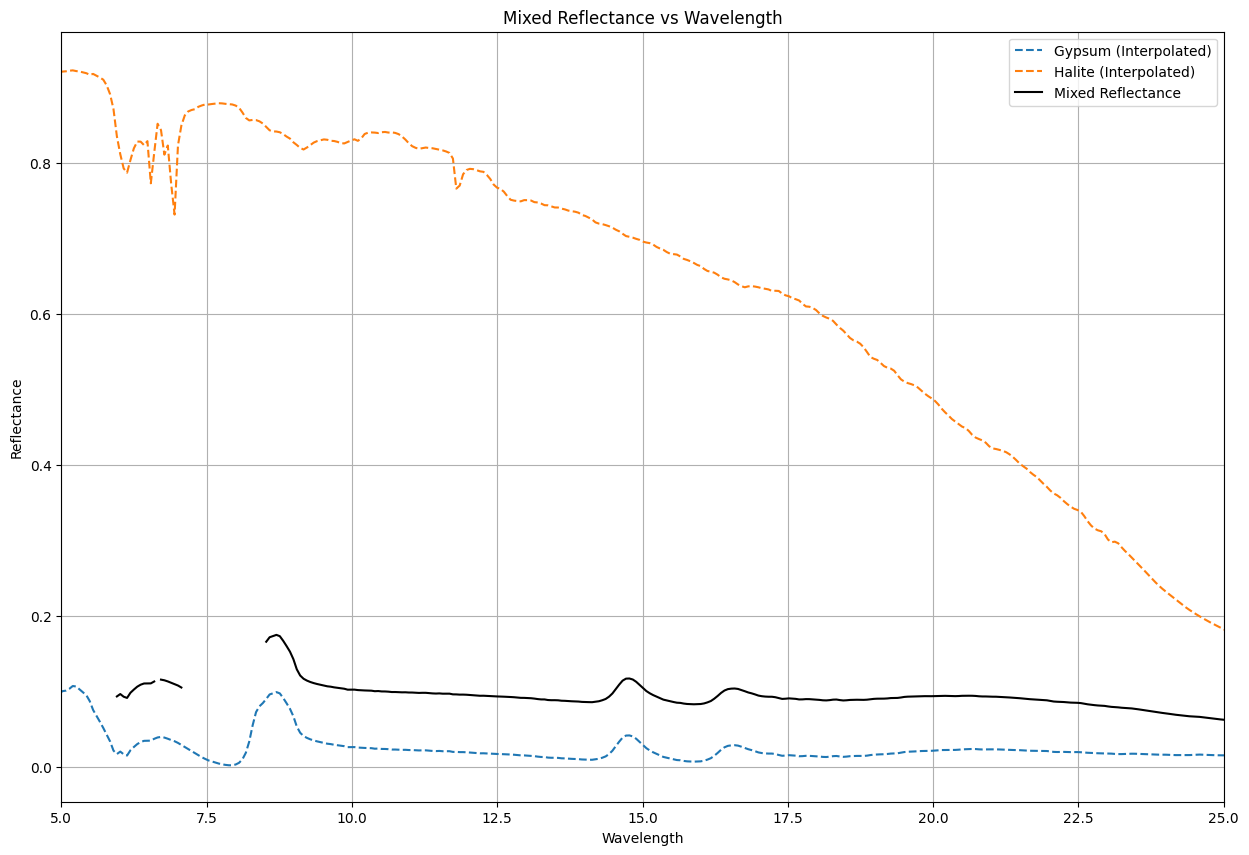

In [7]:
import matplotlib.pyplot as plt

wav_common, R_mix, refl_common_list = hapke_mixing_model(
    reflectance_list=[refl1, refl2],
    wavelength_list=[wav1, wav2],
    n_list=[n1, n2],
    k_list=[k1, k2],
    fractions=fractions,
    angles=angles,
    params=params
)

# Plot the spectra
plt.figure(figsize=(15, 10))
plt.plot(wav_common, refl_common_list[0], label='Gypsum (Interpolated)', linestyle='--')
plt.plot(wav_common, refl_common_list[1], label='Halite (Interpolated)', linestyle='--')
plt.plot(wav_common, R_mix, label='Mixed Reflectance', color='black')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Mixed Reflectance vs Wavelength')
plt.legend()
plt.xlim(5, 25)
plt.grid(True)
plt.show()


In [8]:
# Define the parameter ranges
theta_bar_values = np.radians([0, 10, 20, 30, 40])  # Vary from 0° to 40°
b_values = [0.0, 0.3, 0.6, 0.9]  # Asymmetry parameter
c_values = [0.0, 0.5, 1.0]       # Backward scattering fraction
phi_values = [0.1, 0.4, 0.7, 1.0]  # Filling factor
B_S0_values = [0.0, 0.05, 0.1, 0.15]  # Opposition effect amplitude


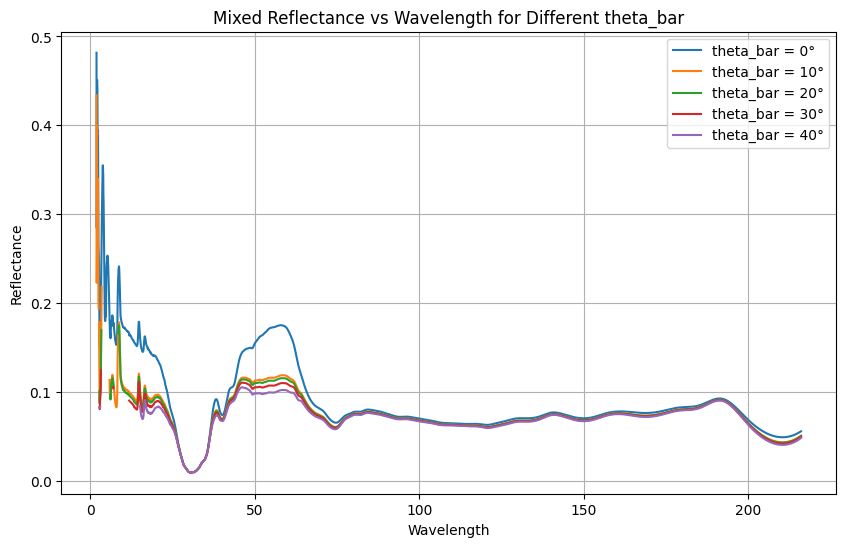

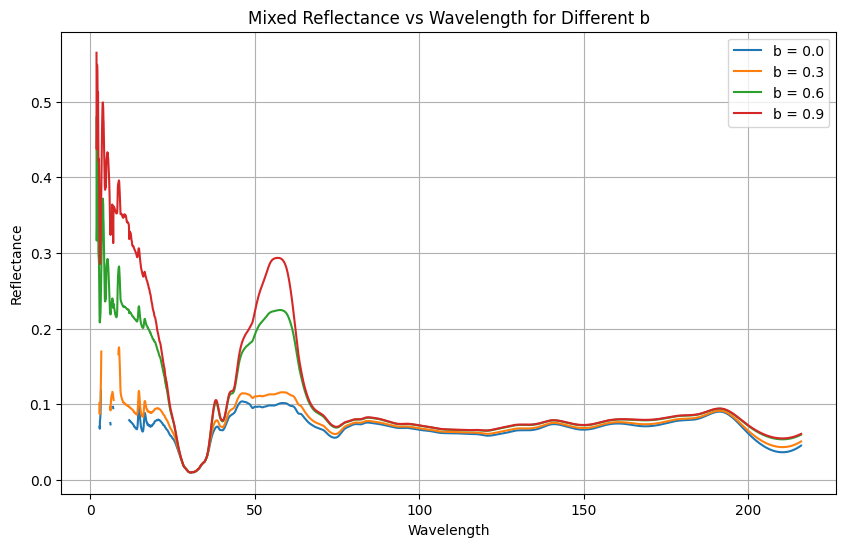

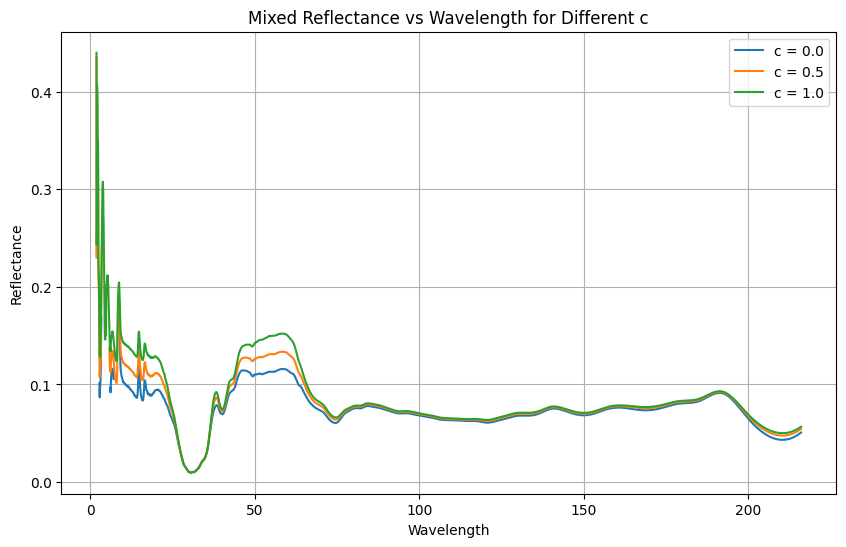

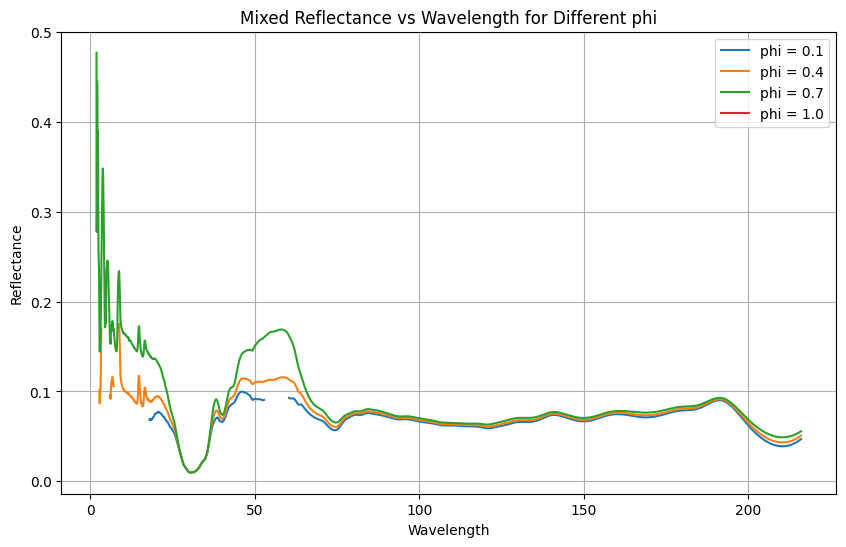

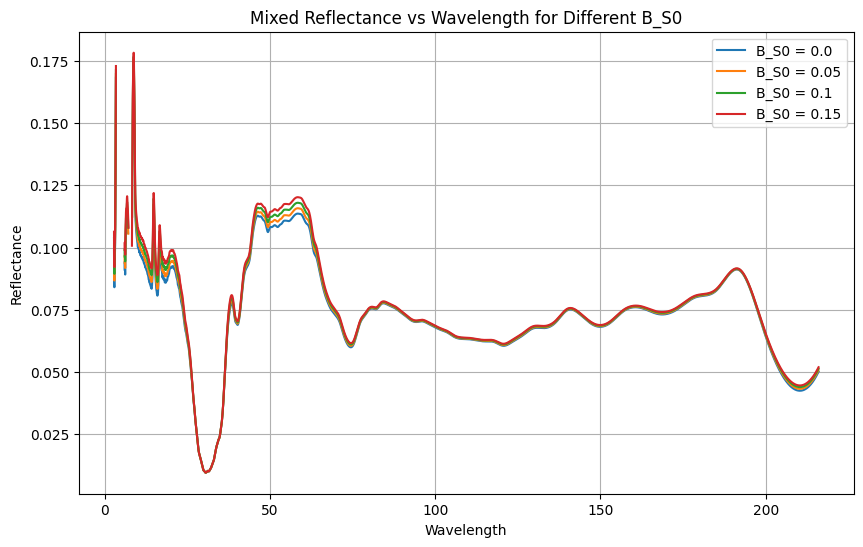

In [9]:
def ablation_study(parameter_name, parameter_values, fixed_params):
    plt.figure(figsize=(10, 6))
    for value in parameter_values:
        params_vary = fixed_params.copy()
        params_vary[parameter_name] = value
        
        wav_common, R_mix, _ = hapke_mixing_model(
            reflectance_list=[refl1, refl2],
            wavelength_list=[wav1, wav2],
            n_list=[n1, n2],
            k_list=[k1, k2],
            fractions=fractions,
            angles=angles,
            params=params_vary
        )
        
        if parameter_name == 'theta_bar':
            label = f'{parameter_name} = {np.degrees(value):.0f}°'
        else:
            label = f'{parameter_name} = {value}'
        plt.plot(wav_common, R_mix, label=label)
    
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title(f'Mixed Reflectance vs Wavelength for Different {parameter_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Now you can call this function for different parameters
ablation_study('theta_bar', theta_bar_values, params)
ablation_study('b', b_values, params)
ablation_study('c', c_values, params)
ablation_study('phi', phi_values, params)
ablation_study('B_S0', B_S0_values, params)


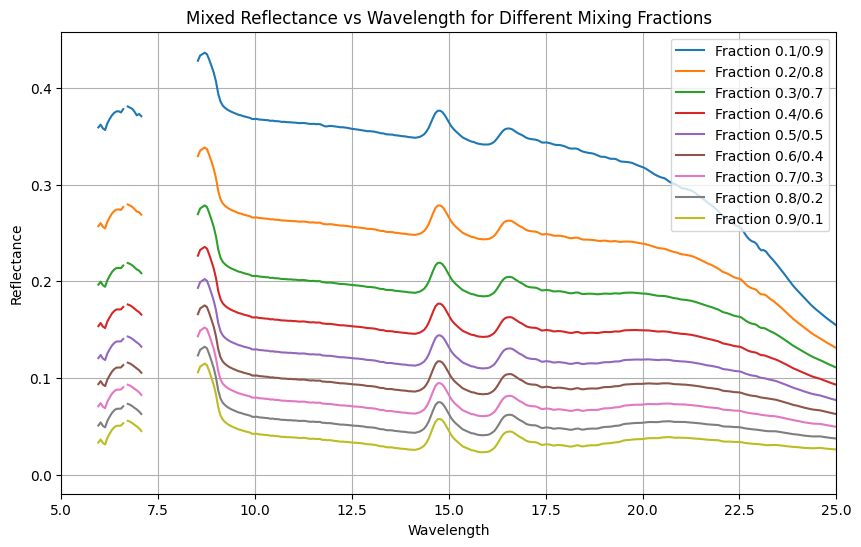

In [10]:
alpha_values = np.linspace(0.1, 0.9, 9)

plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    fractions = [alpha, 1 - alpha]
    
    wav_common, R_mix, _ = hapke_mixing_model(
        reflectance_list=[refl1, refl2],
        wavelength_list=[wav1, wav2],
        n_list=[n1, n2],
        k_list=[k1, k2],
        fractions=fractions,
        angles=angles,
        params=params
    )
    
    label = f'Fraction {alpha:.1f}/{1 - alpha:.1f}'
    plt.plot(wav_common, R_mix, label=label)

plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Mixed Reflectance vs Wavelength for Different Mixing Fractions')
plt.legend()
plt.grid(True)
plt.xlim(5, 25)
plt.show()

Loaded 119 rows from table 'minerals' in DB 'minspec.db'
Exported data -> RAWmineral_data.csv
DataFrame shape: (119, 6)
Unique names in DB: ['Lizardite' 'Bloedite' 'Illite' 'Jarosite' 'Anhydrite' 'Thenardite'
 'Epsomite' 'Tremolite' 'Antigorite' 'Talc' 'Calcite' 'Pyrite' 'Alunite'
 'Halite' 'Dolomite' 'Sulfur' 'Montmorillonite' 'Siderite' 'Enstatite'
 'Bassanite' 'Mirabilite' 'Magnetite' 'Cronstedtite' 'Gypsum' 'Brucite'
 'Trona' 'Nesquehonite' 'Graphite' 'Magnesite' 'Quartz' 'Sylvite'
 'Nahcolite' 'Hydromagnesite' 'Hydrohalite' 'Water_Ice' 'Ikaite']
Library built with minerals: ['Halite', 'Gypsum']
Synthetic mixture created: [0.6, 0.4] (Gypsum/Halite)


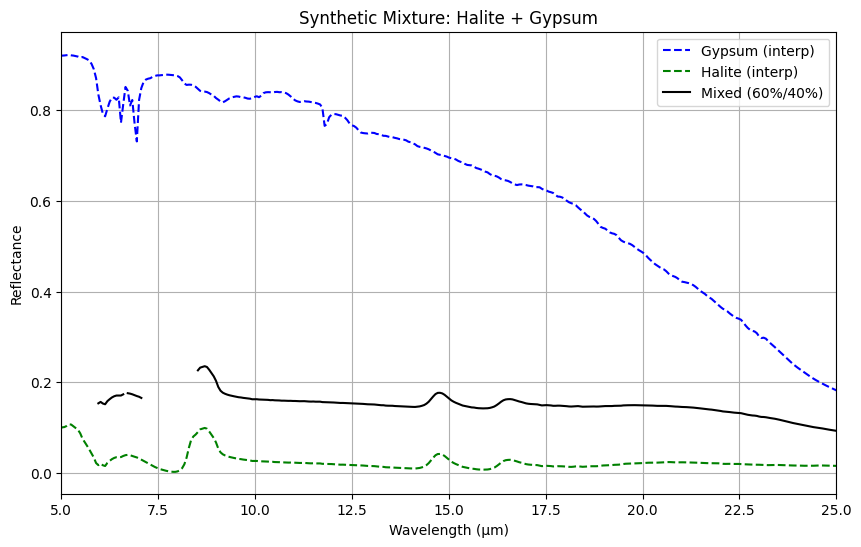

In [ ]:
import sqlite3
import csv
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# SciPy + JAX stuff
from scipy.interpolate import UnivariateSpline
from scipy.optimize import (
    differential_evolution, dual_annealing, shgo, minimize, Bounds, root_scalar
)
from scipy.stats import entropy
import jax
import jax.numpy as jnp

###############################################################################
# 0) CONNECT TO DB, EXPORT TO CSV, READ INTO DATAFRAME
###############################################################################
def load_db_to_df(db_path='minspec.db', table='minerals'):
    """
    Connects to the DB, exports everything from `table` to a CSV, 
    then loads into a Pandas DataFrame.
    """
    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        # get table schema
        cursor.execute(f"SELECT * FROM {table}")
        rows = cursor.fetchall()
        colnames = [desc[0] for desc in cursor.description]
        print(f"Loaded {len(rows)} rows from table '{table}' in DB '{db_path}'")

        # export to CSV
        with open("RAWmineral_data.csv",'w', newline='') as csv_file:
            writer = csv.writer(csv_file, delimiter='\t')
            writer.writerow(colnames)
            writer.writerows(rows)
        print("Exported data -> RAWmineral_data.csv")
    except Exception as e:
        raise RuntimeError(f"Error loading DB: {e}")
    finally:
        conn.close()

    # read CSV into DataFrame
    df = pd.read_csv("RAWmineral_data.csv", delimiter='\t')
    return df

def safe_eval_to_array(x):
    """
    Converts a string like '[1.0, 2.0, 3.0]' -> np.array([1.0,2.0,3.0])
    or returns None if fail.
    """
    if pd.isnull(x) or x=='None':
        return None
    try:
        arr = list(map(float, eval(x)))  # e.g. string -> list of floats
        return np.array(arr,dtype=float)
    except:
        return None

###############################################################################
# 1) BUILD LIBRARY
###############################################################################
def build_subset_library(df):
    """
    Pull exactly 'Halite' and 'Gypsum' from df['name'] 
    (after stripping whitespace).
    Returns: reflectance_list, wavelength_list, n_list, k_list
    for those two minerals (if found).
    """
    # Remove leading/trailing whitespace from 'name'
    df['name'] = df['name'].astype(str).str.strip()

    reflectance_list = []
    wavelength_list  = []
    n_list = []
    k_list = []

    # EXACT MATCH: "Halite"
    sub_halite = df[df['name']=="Halite"]
    if len(sub_halite)==0:
        print("ERROR: No EXACT row found for 'Halite'. Check if your DB or naming differs.")
    else:
        row = sub_halite.iloc[0]
        wv  = row['wavelengths']
        rf  = row['reflectances']
        reflectance_list.append([rf])
        wavelength_list.append([wv])
        n_list.append(1.557)  # known for Halite
        k_list.append(0.132)

    # EXACT MATCH: "Gypsum"
    sub_gypsum = df[df['name']=="Gypsum"]
    if len(sub_gypsum)==0:
        print("ERROR: No EXACT row found for 'Gypsum'. Check if your DB or naming differs.")
    else:
        row = sub_gypsum.iloc[0]
        wv  = row['wavelengths']
        rf  = row['reflectances']
        reflectance_list.append([rf])
        wavelength_list.append([wv])
        n_list.append(1.533)  # known for Gypsum
        k_list.append(0.109)

    return reflectance_list, wavelength_list, n_list, k_list


###############################################################################
# 2) HAPKE MODEL & INVERSION
###############################################################################
PI = np.pi

def porosity_parameter(phi):
    if phi==0:
        return 1.0
    return -jnp.log(1 - 1.209*(phi**(2/3)))/(1.209*(phi**(2/3))+1e-12)

def H_function(w, x):
    gamma = jnp.sqrt(1-w)
    r0 = (1-gamma)/(1+gamma)
    x = jnp.clip(x,1e-6,1)
    return 1/(1 - w*x*(r0 + ((1-2*r0*x)/2)*jnp.log((1+x)/x+1e-12)))

def phase_function(b, c, g):
    cos_g = jnp.cos(g)
    denom1 = (1+2*b*cos_g + b**2)**1.5
    denom2 = (1-2*b*cos_g + b**2)**1.5
    P = ((1-c)/2)*(1-b**2)/denom1 + ((1+c)/2)*(1-b**2)/denom2
    return P

def shoe(B_S0, phi, g):
    h_s = 3*porosity_parameter(phi)*phi/8
    h_s = jnp.clip(h_s,1e-6,None)
    B_SH = 1/(1 + jnp.tan(g/2)/h_s)
    return 1 + B_S0*B_SH

def roughness_correction(mu0, mu, g, theta_bar):
    if theta_bar<1e-12:
        return 1.0
    cos_tb = jnp.cos(theta_bar)
    denom = jnp.clip(mu0+mu,1e-12,None)
    S = cos_tb/denom
    return jnp.clip(S,1e-6,1)

def hapke_reflectance(w, mu0, mu, g, params):
    """
    Single scattering albedo -> reflectance factor
    """
    theta_bar = params['theta_bar']
    b = params['b']
    c = params['c']
    phi = params['phi']
    B_S0= params['B_S0']

    K = porosity_parameter(phi)
    p = phase_function(b, c, g)
    B_SH= shoe(B_S0, phi, g)
    S   = roughness_correction(mu0, mu, g, theta_bar)

    H_mu0 = H_function(w, mu0)
    H_mu  = H_function(w, mu)
    denom = jnp.clip(mu0+mu,1e-12,None)
    r = (K*w/(4*PI))*(mu0/denom)*(p*B_SH + H_mu0*H_mu -1)*S
    return r*PI

def invert_hapke_reflectance_spectrum(R_spectrum, mu0, mu, g, params):
    """
    For each R in R_spectrum, invert -> w using brentq root finder.
    """
    w_est = np.zeros_like(R_spectrum)
    for i,val in enumerate(R_spectrum):
        if not np.isfinite(val):
            w_est[i]=np.nan
            continue
        def f(w):
            return float(hapke_reflectance(w, mu0, mu, g, params) - val)
        try:
            sol = root_scalar(f, bracket=[1e-6,1-1e-6], method='brentq', xtol=1e-8)
            if sol.converged:
                w_est[i] = sol.root
            else:
                w_est[i] = np.nan
        except:
            w_est[i] = np.nan
    return w_est

###############################################################################
# 3) FORWARD MIXING
###############################################################################
from scipy.interpolate import UnivariateSpline

def cauchy_equation(wav, A, B, C=0):
    return A + B/(wav**2) + C/(wav**4)

def model_nk_wavelength_dependence(wav_common, n_scalar, k_scalar):
    # trivial cauchy
    n_wav = cauchy_equation(wav_common, n_scalar, 0, 0)
    k_wav = np.full_like(wav_common, k_scalar)
    return n_wav,k_wav

def interpolate_reflectance(wav, refl, wav_common):
    # simple cubic spline
    spline = UnivariateSpline(wav, refl, s=0, k=3)
    return spline(wav_common)

def mix_single_scattering_albedo(w_list, fractions):
    w_mix = np.zeros_like(w_list[0])
    for wi, fi in zip(w_list, fractions):
        w_mix += fi*wi
    return np.clip(w_mix,0,1)

def hapke_mixing_model(reflectance_list, wavelength_list, n_list, k_list, fractions, angles, params):
    # find overlap
    wave_mins = []
    wave_maxs = []
    for wv_ in wavelength_list:
        arr = wv_[0]
        wave_mins.append(arr.min())
        wave_maxs.append(arr.max())
    Wmin = max(wave_mins)
    Wmax = min(wave_maxs)
    if Wmin>=Wmax:
        raise ValueError("No overlapping range among endmember wavelengths.")

    # define common grid
    n_points = max(len(wv_[0]) for wv_ in wavelength_list)
    wav_common = np.linspace(Wmin, Wmax, n_points)

    # interpolate each endmember
    refl_common_list = []
    for (wv, rf) in zip(wavelength_list, reflectance_list):
        arr_w = wv[0]
        arr_r = rf[0]
        R_new = interpolate_reflectance(arr_w, arr_r, wav_common)
        refl_common_list.append(R_new)

    # angles
    i = np.radians(angles[0])
    e = np.radians(angles[1])
    g = np.radians(angles[2])
    mu0 = np.cos(i)
    mu  = np.cos(e)

    # invert each reflectance -> w
    w_list = []
    for (R_meas, n_val, k_val) in zip(refl_common_list, n_list, k_list):
        n_wav, k_wav = model_nk_wavelength_dependence(wav_common, n_val, k_val)
        local_params = params.copy()
        local_params['n'] = n_wav
        local_params['k'] = k_wav
        w_est = invert_hapke_reflectance_spectrum(R_meas, mu0, mu, g, local_params)
        w_list.append(w_est)

    # mix w_i
    w_mix = mix_single_scattering_albedo(w_list, fractions)
    # forward reflectance
    def hapke_vec(w):
        return hapke_reflectance(w, mu0, mu, g, params)
    R_mix = np.array([float(hapke_vec(ww)) for ww in w_mix])
    return wav_common, R_mix, refl_common_list

###############################################################################
# 4) UNMIX (GLOBAL + LOCAL + COV)
###############################################################################
def robust_hapke_unmix_objective(
    f_raw,
    reflectance_list, wavelength_list, n_list, k_list,
    angles, params, hapke_mixing_model,
    R_meas, wav_meas,
    penalty_lambda=0.01, alpha=0.7
):
    N = len(f_raw)
    tot = np.sum(f_raw)
    if tot<1e-12:
        fractions = np.ones(N)/N
    else:
        fractions = f_raw/tot

    try:
        wav_model, R_model, _ = hapke_mixing_model(
            reflectance_list, wavelength_list,
            n_list, k_list,
            fractions, angles, params
        )
    except:
        return 1e15

    # if mismatch length
    if len(wav_model)!=len(wav_meas):
        R_model = np.interp(wav_meas, wav_model, R_model)

    # robust Huber
    residuals = R_meas - R_model
    delta = 0.1*np.nanmax(R_meas)
    abs_res = np.abs(residuals)
    mask = (abs_res<=delta)
    huber_in = 0.5*(residuals[mask]**2)
    huber_out= delta*(abs_res[~mask]) - 0.5*(delta**2)
    huber_sum= np.sum(huber_in) + np.sum(huber_out)

    # reg
    from scipy.stats import entropy
    l1_term = alpha*np.sum(np.abs(fractions))
    l2_term = (1-alpha)*np.sum(fractions**2)
    ent_term= 0.1*entropy(fractions+1e-12)

    return huber_sum + penalty_lambda*(l1_term + l2_term) + ent_term

def make_jax_objective(
    reflectance_list, wavelength_list, n_list, k_list,
    angles, params, hapke_mixing_model,
    R_meas, wav_meas,
    penalty_lambda=0.01, alpha=0.7
):
    def jax_obj_func(f_jax):
        f_np = np.array(f_jax,dtype=float)
        val = robust_hapke_unmix_objective(
            f_np,
            reflectance_list, wavelength_list, n_list, k_list,
            angles, params, hapke_mixing_model,
            R_meas, wav_meas,
            penalty_lambda, alpha
        )
        return jnp.array(val, dtype=jnp.float64)
    return jax_obj_func

def hapke_unmix_global_local_cov(
    R_meas, wav_meas,
    reflectance_list, wavelength_list, n_list, k_list,
    angles, params, hapke_mixing_model,
    penalty_lambda=0.01, alpha=0.7,
    global_methods=('differential_evolution','dual_annealing','shgo'),
    do_local_refine=True,
    n_restarts=1
):
    N = len(reflectance_list)
    jax_obj = make_jax_objective(
        reflectance_list, wavelength_list, n_list, k_list,
        angles, params, hapke_mixing_model,
        R_meas, wav_meas,
        penalty_lambda, alpha
    )
    def py_obj(x):
        return float(jax_obj(jnp.array(x,dtype=jnp.float64)))

    bounds = [(0,1)]*N
    best_f, best_obj = None, 1e15

    # GLOBAL
    for method in global_methods:
        for seed in range(n_restarts):
            if method=='differential_evolution':
                res = differential_evolution(py_obj, bounds=bounds, 
                                             maxiter=300, popsize=15, 
                                             polish=False, seed=seed)
            elif method=='dual_annealing':
                res = dual_annealing(py_obj, bounds=bounds, 
                                     maxiter=300, seed=seed)
            elif method=='shgo':
                res = shgo(py_obj, bounds=bounds, iters=2, sampling_method='sobol')
            else:
                raise ValueError("Unknown method: "+method)
            if res.success and res.fun<best_obj:
                best_obj = res.fun
                best_f   = res.x

    if best_f is None:
        raise RuntimeError("Global optimization failed to find any solution")

    best_f = np.array(best_f,dtype=float)
    best_f /= (best_f.sum()+1e-12)

    # LOCAL
    if do_local_refine:
        grad_fn = jax.grad(jax_obj)
        from scipy.optimize import minimize, Bounds
        def local_obj_and_grad(x):
            val = py_obj(x)
            g   = grad_fn(jnp.array(x,dtype=jnp.float64))
            return val, np.array(g,dtype=float)
        def local_obj(x):
            v,_=local_obj_and_grad(x)
            return v
        def local_jac(x):
            _,g=local_obj_and_grad(x)
            return g
        def constraint_sum1(x):
            return np.sum(x)-1

        local_bounds = Bounds([0]*N, [1]*N)
        cons = {'type':'eq','fun':constraint_sum1}
        res_local = minimize(local_obj,best_f,method='SLSQP',
                             jac=local_jac,bounds=local_bounds,
                             constraints=cons,options={'maxiter':500})
        if res_local.success:
            new_f = res_local.x
            new_f /= (new_f.sum()+1e-12)
            if res_local.fun<best_obj:
                best_obj = res_local.fun
                best_f   = new_f

    # Evaluate final
    best_f = np.array(best_f,dtype=float)
    wav_model, R_fit, _ = hapke_mixing_model(
        reflectance_list, wavelength_list, n_list, k_list,
        best_f, angles, params
    )
    if len(wav_model)!=len(wav_meas):
        R_fit = np.interp(wav_meas,wav_model,R_fit)
    final_obj = best_obj

    # Cov
    jax_hessian = jax.jacfwd(jax.grad(jax_obj))
    H_val = jax_hessian(jnp.array(best_f,dtype=jnp.float64))
    H_np  = np.array(H_val,dtype=float)
    try:
        cov_mat = np.linalg.inv(H_np)
    except np.linalg.LinAlgError:
        cov_mat = None

    return best_f, R_fit, final_obj, cov_mat

def hapke_unmix_bootstrap(
    R_meas, wav_meas,
    reflectance_list,wavelength_list,n_list,k_list,
    angles, params, hapke_mixing_model,
    n_boot=3, noise_std=0.01,
    **unmix_kwargs
):
    N = len(reflectance_list)
    frac_array = np.zeros((n_boot,N))
    for i in range(n_boot):
        noise = np.random.normal(loc=0,scale=noise_std,size=R_meas.shape)
        R_perturbed = R_meas + noise*R_meas
        f_est, R_fit, obj_val, cov_mat = hapke_unmix_global_local_cov(
            R_perturbed, wav_meas,
            reflectance_list, wavelength_list, n_list, k_list,
            angles, params, hapke_mixing_model,
            **unmix_kwargs
        )
        frac_array[i,:] = f_est
    return frac_array


###############################################################################
# 5) MAIN DEMO
###############################################################################
if __name__=="__main__":
    # 1) Load from DB -> df
    df = load_db_to_df(db_path='minspec.db', table='minerals')

    # Convert 'wavelengths' & 'reflectances' to np.array
    df['wavelengths']   = df['wavelengths'].apply(safe_eval_to_array)
    df['reflectances']  = df['reflectances'].apply(safe_eval_to_array)

    print("DataFrame shape:", df.shape)
    print("Unique names in DB:", df['name'].unique())

    # 2) EXACT MATCH 'Halite' & 'Gypsum', build library
    reflectance_list, wavelength_list, n_list, k_list = build_subset_library(df)
    if len(reflectance_list)<2:
        print("ERROR: Did not find both Halite & Gypsum. Exiting.")
        import sys
        sys.exit(0)
    print("Library built with minerals:", ["Halite","Gypsum"])

    # 3) Hapke parameters
    angles = (0,0,0)  # inc=0°, eme=0°, phase=0°
    params = {
      'theta_bar': np.radians(20),
      'b': 0.3,
      'c': 0.0,
      'phi': 0.4,
      'B_S0': 0.05
    }

    # 4) Make synthetic mixture (Gypsum=60%, Halite=40%)
    fractions_true = [0.6,0.4]
    wav_common, R_mix, refl_common_list = hapke_mixing_model(
        reflectance_list, wavelength_list, n_list, k_list,
        fractions_true, angles, params
    )
    print(f"Synthetic mixture created: {fractions_true} (Gypsum/Halite)")

    # plot
    plt.figure(figsize=(10,6))
    plt.plot(wav_common, refl_common_list[0], 'b--', label='Gypsum (interp)')
    plt.plot(wav_common, refl_common_list[1], 'g--', label='Halite (interp)')
    plt.plot(wav_common, R_mix, 'k-', label='Mixed (60%/40%)')
    plt.title("Synthetic Mixture: Halite + Gypsum")
    plt.xlabel("Wavelength (µm)")
    plt.ylabel("Reflectance")
    plt.xlim(5,25)
    plt.grid(True)
    plt.legend()
    plt.show()

    # 5) Unmix
    f_best, R_fit, final_obj, cov_mat = hapke_unmix_global_local_cov(
        R_meas=R_mix,
        wav_meas=wav_common,
        reflectance_list=reflectance_list,
        wavelength_list=wavelength_list,
        n_list=n_list, k_list=k_list,
        angles=angles, params=params,
        hapke_mixing_model=hapke_mixing_model,
        penalty_lambda=0.01,
        alpha=0.7,
        global_methods=('differential_evolution','dual_annealing','shgo'),
        do_local_refine=True,
        n_restarts=1
    )
    print("\n===== UNMIXING RESULTS =====")
    print("True fractions:", fractions_true)
    print("Recovered fractions:", f_best)
    print("Objective:", final_obj)
    print("Covariance:\n", cov_mat)

    # plot fit
    plt.figure(figsize=(10,6))
    plt.plot(wav_common, R_mix, 'k--', label='Observed Mixture')
    plt.plot(wav_common, R_fit, 'r-', label='Unmix Fit')
    plt.title("Hapke Unmixing Fit: Halite/Gypsum")
    plt.xlabel("Wavelength (µm)")
    plt.ylabel("Reflectance")
    plt.xlim(5,25)
    plt.grid(True)
    plt.legend()
    plt.show()

    # 6) Bootstrap
    print("\nPerforming 3-run bootstrap for fraction uncertainty:")
    fractions_array = hapke_unmix_bootstrap(
        R_meas=R_mix,
        wav_meas=wav_common,
        reflectance_list=reflectance_list,
        wavelength_list=wavelength_list,
        n_list=n_list,
        k_list=k_list,
        angles=angles,
        params=params,
        hapke_mixing_model=hapke_mixing_model,
        n_boot=3,
        noise_std=0.01,
        penalty_lambda=0.01,
        alpha=0.7,
        global_methods=('differential_evolution','dual_annealing','shgo'),
        do_local_refine=True,
        n_restarts=1
    )
    mean_f = fractions_array.mean(axis=0)
    std_f  = fractions_array.std(axis=0)
    print("Bootstrap mean:", mean_f)
    print("Bootstrap std:", std_f)
